In [7]:
%run Global.ipynb
%run Helper_Functions.ipynb

In [15]:
train_df_ohe_selected = pd.read_csv("./Final/Datasets/train_df.csv", keep_default_na=False)

X = train_df_ohe_selected.iloc[:,:-1] # (transformed) attributes
y = train_df_ohe_selected.iloc[:,-1]  # ground truth labels

In [16]:
# run in terminal: python -m pip install mlxtend
# https://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/#example-3-stacked-cv-classification-and-gridsearch
import mlxtend
from mlxtend.classifier import StackingCVClassifier

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm

## StackingClf1 - 5 Base with individually tuned hyperparameters

### Tune base classifiers

In [ ]:
# tune knn
knn = KNeighborsClassifier(n_neighbors=3)
param_grid = {'n_neighbors': [1, 5, 10, 15]}
grid_knn = tune_hyperparameter(knn, param_grid, X, y, cv=4)
print(max(grid_knn['mean_test_accuracy']))
grid_knn.loc[grid_knn['mean_test_accuracy'] == max(grid_knn['mean_test_accuracy'])]['params'].values

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
y_pred_knn, knn_report = cross_val_report(knn, X, y)
knn_report

In [ ]:
# tune dt
dt = DecisionTreeClassifier(random_state = 30027)
dt.get_params()
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [200, 400, 600]}
grid_dt = tune_hyperparameter(dt, param_grid, X, y, cv = 3)
print(max(grid_dt['mean_test_accuracy']))
grid_dt.loc[grid_dt['mean_test_accuracy'] == max(grid_dt['mean_test_accuracy'])]['params'].values

In [ ]:
dt = DecisionTreeClassifier(criterion = "entropy", max_depth = 400, random_state = 30027)
y_pred_dt, dt_report = cross_val_report(dt, X, y)
dt_report

In [ ]:
# tune mnb
mnb = MultinomialNB()
param_grid = {'alpha': [0.1, 0.5, 1,2]}
grid_mnb = tune_hyperparameter(mnb, param_grid, X, y, cv=4)
print(max(grid_mnb['mean_test_accuracy']))
grid_mnb.loc[grid_mnb['mean_test_accuracy'] == max(grid_mnb['mean_test_accuracy'])]['params'].values

In [ ]:
mnb = MultinomialNB(alpha=1)
y_pred_mnb, mnb_report = cross_val_report(mnb, X, y)
mnb_report

In [ ]:
# tune svm
linearSVM = svm.LinearSVC(dual=False, random_state=30027)
param_grid = {'C': [1,3,5]}
grid_svm = tune_hyperparameter(linearSVM, param_grid, X, y, cv=4)
print(max(grid_svm['mean_test_accuracy']))
grid_svm.loc[grid_svm['mean_test_accuracy'] == max(grid_svm['mean_test_accuracy'])]['params'].values

In [ ]:
linearSVM = svm.LinearSVC(dual=False, C=5, random_state=30027)
y_pred_svm, svm_report = cross_val_report(linearSVM, X, y)
svm_report

In [ ]:
# base classifiers with individually tuned hyperparameters
mnb = MultinomialNB(alpha=1)
linearSVM = svm.LinearSVC(C=5, dual=False, random_state=30027)
logr = LogisticRegression(solver='sag', max_iter=50, random_state = 30027)
dt = DecisionTreeClassifier(criterion = "entropy", max_depth = 400, random_state = 30027)
knn = KNeighborsClassifier(n_neighbors=15)

sclf5 = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, dt, knn], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)
y_pred5, sclf5_report = cross_val_report(sclf5, X, y)
sclf5_report

### diversity

In [ ]:
clfs = ["mnb", "svm", "logr", "dt", "knn"]
preds0 = [cross_val_report(clf, X, y)[0] for clf in [mnb, linearSVM, logr, dt, knn]]
predictions0 = pd.DataFrame({clfs[i]:preds0[i] for i in range(5)})
differences0 = {clf:[] for clf in clfs}
for clf1 in clfs: 
    for clf2 in clfs: 
        differences0[clf1].append(sum(predictions0[clf1] != predictions0[clf2]))
differences0 = pd.DataFrame(differences0, index = clfs)
differences0.style.background_gradient(cmap='Blues')

## StackingClf2 - 5 Base Classifiers with tuned hyperparameter

In [ ]:
sclf5 = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, dt, knn], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)
param_grid = {'linearsvc__C': [1,5], 'multinomialnb__alpha': [0.5, 1], 'logisticregression__max_iter': [50, 100], 'decisiontreeclassifier__max_depth': [200, 400], 'kneighborsclassifier__n_neighbors': [5, 10, 15]}
grid5 = tune_hyperparameter(sclf5, param_grid, X, y, cv=2)
print(max(grid5['mean_test_accuracy']))
grid5.loc[grid5['mean_test_accuracy'] == max(grid5['mean_test_accuracy'])]['params'].values

In [ ]:
# base classifiers with tuned hyperparameters
mnb = MultinomialNB(alpha = 1)
linearSVM = svm.LinearSVC(C=5, dual=False,random_state=30027)
logr = LogisticRegression(solver='sag', max_iter=50, random_state = 30027)
dt = DecisionTreeClassifier(max_depth = 200, random_state = 30027)
knn = KNeighborsClassifier(n_neighbors=10)

sclf5 = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, dt, knn], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)
y_pred5, sclf5_report = cross_val_report(sclf5, X, y)
sclf5_report

### diversity

In [ ]:
clfs = ["mnb", "svm", "logr", "dt", "knn"]
preds1 = [cross_val_report(clf, X, y)[0] for clf in [mnb, linearSVM, logr, dt, knn]]
predictions1 = pd.DataFrame({clfs[i]:preds1[i] for i in range(5)})
differences1 = {clf:[] for clf in clfs}
for clf1 in clfs: 
    for clf2 in clfs: 
        differences1[clf1].append(sum(predictions1[clf1] != predictions1[clf2]))
differences1 = pd.DataFrame(differences1, index = clfs)
differences1.style.background_gradient(cmap='Blues')

## Comparison between SVM, StackingClf1, StackingClf2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
performances = {'Metrics': ['3-precision', '3-recall', '4-precision', '4-recall', '5-precision', '5-recall','accuracy'],
                'SVM': [0.745, 0.183, 0.739, 0.969, 0.533, 0.199, 0.736],
                'Stacking_Clf_1': [0.678, 0.212, 0.743, 0.957, 0.602, 0.209, 0.736],
                'Stacking_Clf_2': [0.705, 0.198, 0.742, 0.963, 0.589, 0.214, 0.737]}
performance_df = pd.DataFrame(performances, columns = ['Metrics', 'SVM', 'Stacking_Clf_1', 'Stacking_Clf_2'])
print(performance_df)

pos = list(range(len(performance_df['SVM'])))
width = 0.25

fig, ax = plt.subplots(figsize = (10,5))
plt.bar(pos, performance_df['SVM'], width, alpha=0.5, color='Red')
plt.bar([p+width for p in pos], performance_df['Stacking_Clf_1'], width, alpha=0.5, color='Orange')
plt.bar([p+width*2 for p in pos], performance_df['Stacking_Clf_2'], width, alpha=0.5, color='Green')
ax.set_ylabel('Performance')
ax.set_title('Classifier Performance')
ax.set_xticks([p+1.5*width for p in pos])
ax.set_xticklabels(performance_df['Metrics'])
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0.15, 1])

plt.legend(['SVM', 'Stacking_Clf_1', 'Stacking_Clf_2'], loc='upper left')
plt.grid()
plt.show()

## 4 Base Classifiers

### remove kNN

In [18]:
mnb = MultinomialNB(alpha = 1)
linearSVM = svm.LinearSVC(C=5, dual=False,random_state=30027)
logr = LogisticRegression(solver='sag', max_iter=50, random_state = 30027)
dt = DecisionTreeClassifier(max_depth = 200, random_state = 30027)

sclf_knn = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, dt], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)
param_grid = {'linearsvc__C': [1, 5], 'multinomialnb__alpha': [0.1, 0.5, 1], 'logisticregression__max_iter': [50, 100], 'decisiontreeclassifier__max_depth': [200, 400]}
grid4_cat = tune_hyperparameter(sclf_knn, param_grid, X, y, cv=2)
print(max(grid4_cat['mean_test_accuracy']))
grid4_cat.loc[grid4_cat['mean_test_accuracy'] == max(grid4_cat['mean_test_accuracy'])]['params'].values


Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END decisiontreeclassifier__max_depth=200, linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.1; total time=   9.6s
[CV] END decisiontreeclassifier__max_depth=200, linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.1; total time=   9.9s
[CV] END decisiontreeclassifier__max_depth=200, linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.5; total time=   8.9s
[CV] END decisiontreeclassifier__max_depth=200, linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=0.5; total time=  10.0s
[CV] END decisiontreeclassifier__max_depth=200, linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=1; total time=   9.1s
[CV] END decisiontreeclassifier__max_depth=200, linearsvc__C=1, logisticregression__max_iter=50, multinomialnb__alpha=1; total time=  10.5s
[CV] END decisiontreeclassifier__max_depth=200, linearsvc__C=1, logisticregression__max_ite

array([{'decisiontreeclassifier__max_depth': 200, 'linearsvc__C': 5, 'logisticregression__max_iter': 50, 'multinomialnb__alpha': 1},
       {'decisiontreeclassifier__max_depth': 200, 'linearsvc__C': 5, 'logisticregression__max_iter': 100, 'multinomialnb__alpha': 1}],
      dtype=object)

StackingCVClassifier prediction took 184.0039768218994 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.707182    0.218058      0.333333       0.743541    0.958667   
1       0.708333    0.202726      0.315232       0.741584    0.964837   
2       0.682081    0.201365      0.310935       0.741305    0.959901   
3       0.680723    0.192833      0.300532       0.739934    0.963603   
4       0.754491    0.215017      0.334661       0.743250    0.967921   
5       0.666667    0.184300      0.288770       0.740229    0.958051   
6       0.724138    0.179181      0.287278       0.739539    0.970389   
7       0.713415    0.199659      0.312000       0.742439    0.969155   
8       0.707602    0.206133      0.319261       0.741445    0.962963   
9       0.707792    0.185690      0.294197       0.739336    0.962963   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.837510       0.500000    0.181818      0.266667  0.73

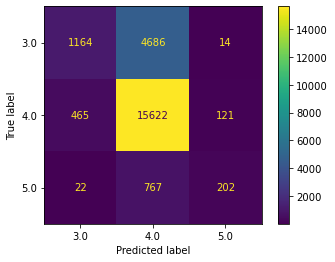

,mean,std
3.0_precision,0.705242,0.024722
3.0_recall,0.198496,0.012962
3.0_f1-score,0.309620,0.016917
4.0_precision,0.741260,0.001497
4.0_recall,0.963845,0.004297
4.0_f1-score,0.838020,0.001874
5.0_precision,0.604271,0.076078
5.0_recall,0.203848,0.036589
5.0_f1-score,0.303082,0.043599
accuracy,0.736591,0.003113


In [19]:
mnb = MultinomialNB(alpha = 1)
linearSVM = svm.LinearSVC(C=5, dual=False,random_state=30027)
logr = LogisticRegression(solver='sag', max_iter=50, random_state = 30027)
dt = DecisionTreeClassifier(max_depth = 200, random_state = 30027)

sclf_knn = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, dt], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)
y_pred_knn, sclf_knn_report = cross_val_report(sclf_knn, X, y)
sclf_knn_report

### remove decision tree

In [ ]:
param_grid = {'linearsvc__C': [1,5], 'multinomialnb__alpha': [0.1, 0.5, 1], 'logisticregression__max_iter': [50, 100], 'kneighborsclassifier__n_neighbors': [5, 10, 15]}
sclf_dt = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, knn], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)
grid_dt = tune_hyperparameter(sclf_dt, param_grid, X, y, cv=2)
print(max(grid_dt['mean_test_accuracy']))
grid_dt.loc[grid_dt['mean_test_accuracy'] == max(grid_dt['mean_test_accuracy'])]['params'].values

In [ ]:
mnb = MultinomialNB(alpha = 2)
linearSVM = svm.LinearSVC(random_state=30027, C=5)
logr = LogisticRegression(solver='sag', max_iter=50, random_state = 30027)
knn = KNeighborsClassifier(n_neighbors=10)

sclf_dt = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, knn], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)
y_pred_dt, sclf_dt_report = cross_val_report(sclf_dt, X, y)
sclf_dt_report

## 3 Base Classifiers

In [ ]:
param_grid = {'linearsvc__C': [1,5], 'multinomialnb__alpha': [0.1, 0.5, 1], 'logisticregression__max_iter': [50, 100]}
sclf3_cat = StackingCVClassifier(classifiers=[mnb, linearSVM, logr], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)
sclf3_cat.meta_classifier = CategoricalNB()
grid_cat = tune_hyperparameter(sclf3_cat, param_grid, X, y, cv=2)
print(max(grid_cat['mean_test_accuracy']))
grid_cat.loc[grid_cat['mean_test_accuracy'] == max(grid_cat['mean_test_accuracy'])]['params'].values

In [ ]:
mnb = MultinomialNB(alpha = 1)
linearSVM = svm.LinearSVC(random_state=30027, C=5)
logr = LogisticRegression(solver='sag', max_iter=50, random_state = 30027)

sclf3_cat = StackingCVClassifier(classifiers=[mnb, linearSVM, logr], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)
y_pred3_cat, sclf3_cat_report = cross_val_report(sclf3_cat, X, y)
sclf3_cat_report

## Choose metaclassifier

============================== Logistic regression ==============================
StackingCVClassifier prediction took 469.1887540817261 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.729032    0.192504      0.304582       0.737213    0.969155   
1       0.726619    0.172061      0.278237       0.735734    0.970389   
2       0.751773    0.180887      0.291609       0.736156    0.975941   
3       0.733813    0.174061      0.281379       0.735691    0.975324   
4       0.774648    0.187713      0.302198       0.737209    0.977791   
5       0.730496    0.175768      0.283356       0.738195    0.974090   
6       0.745902    0.155290      0.257062       0.733025    0.979025   
7       0.770833    0.189420      0.304110       0.741017    0.979642   
8       0.789855    0.185690      0.300690       0.736427    0.979630   
9       0.726027    0.180579      0.289222       0.737850    0.974691   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f

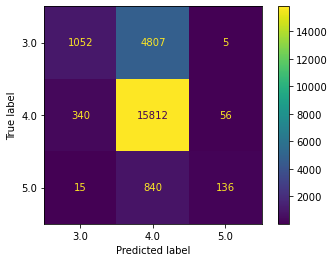

                   mean       std
3.0_precision  0.747900  0.023116
3.0_recall     0.179397  0.010859
3.0_f1-score   0.289245  0.014959
4.0_precision  0.736852  0.002063
4.0_recall     0.975568  0.003668
4.0_f1-score   0.839567  0.001958
5.0_precision  0.689719  0.120869
5.0_recall     0.137283  0.042488
5.0_f1-score   0.227178  0.062595
accuracy       0.737112  0.002908



============================== Categorical naive bayes ==============================
StackingCVClassifier prediction took 467.2307381629944 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.701087    0.219761      0.334630       0.744264    0.960518   
1       0.691358    0.190801      0.299065       0.740038    0.962369   
2       0.689266    0.208191      0.319790       0.741782    0.960518   
3       0.692771    0.196246      0.305851       0.740548    0.966687   
4       0.723757    0.223549      0.341591       0.745098    0.961135   
5       0.683230    0.187713      

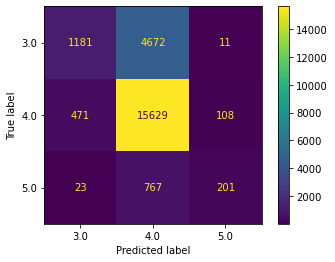

                   mean       std
3.0_precision  0.705311  0.016819
3.0_recall     0.201398  0.013186
3.0_f1-score   0.313110  0.016202
4.0_precision  0.741842  0.001686
4.0_recall     0.964277  0.003470
4.0_f1-score   0.838555  0.001241
5.0_precision  0.630414  0.067867
5.0_recall     0.202869  0.033710
5.0_f1-score   0.305772  0.042815
accuracy       0.737589  0.002164





In [101]:
# 4 base classifiers - removed kNN
sclf = sclf_knn
meta_clfs = {"Logistic regression": LogisticRegression(random_state = 30027), "Categorical naive bayes": CategoricalNB()}
predictions = {}
reports = {}
for name, meta_clf in meta_clfs.items(): 
    sclf.meta_classifier = meta_clf
    print(f'============================== {name} ==============================')
    predictions[name], reports[name] = cross_val_report(sclf, X, y)
    print(reports[name])
    print('\n\n')

## using different number of feature selection

selected 50 features

StackingCVClassifier prediction took 179.56503820419312 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.707182    0.218058      0.333333       0.743541    0.958667   
1       0.708333    0.202726      0.315232       0.741584    0.964837   
2       0.682081    0.201365      0.310935       0.741305    0.959901   
3       0.680723    0.192833      0.300532       0.739934    0.963603   
4       0.754491    0.215017      0.334661       0.743250    0.967921   
5       0.666667    0.184300      0.288770       0.740229    0.958051   
6       0.724138    0.179181      0.287278       0.739539    0.970389   
7       0.713415    0.199659      0.312000       0.742439    0.969155   
8       0.707602    0.206133      0.319261       0.741445    0.962963   
9       0.707792    0.185690      0.294197       0.739336    0.962963   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.837510       0.500000    0.181

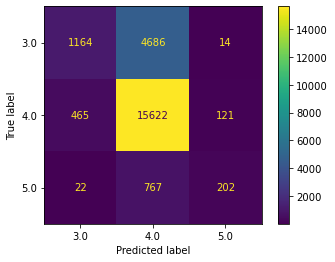

                   mean       std
3.0_precision  0.705242  0.024722
3.0_recall     0.198496  0.012962
3.0_f1-score   0.309620  0.016917
4.0_precision  0.741260  0.001497
4.0_recall     0.963845  0.004297
4.0_f1-score   0.838020  0.001874
5.0_precision  0.604271  0.076078
5.0_recall     0.203848  0.036589
5.0_f1-score   0.303082  0.043599
accuracy       0.736591  0.003113



selected 100 features

StackingCVClassifier prediction took 256.4132900238037 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.695000    0.236797      0.353240       0.746016    0.953115   
1       0.682796    0.216354      0.328590       0.745673    0.956817   
2       0.688525    0.215017      0.327698       0.743295    0.957434   
3       0.640449    0.194539      0.298429       0.739027    0.955583   
4       0.748571    0.223549      0.344284       0.744297    0.966070   
5       0.674157    0.204778      0.314136       0.744019    0.959284   
6       0.701863    0.19

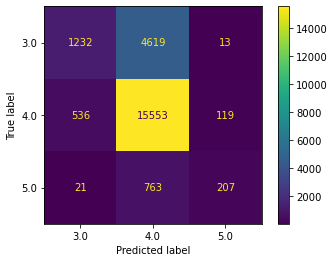

                   mean       std
3.0_precision  0.688786  0.026964
3.0_recall     0.210092  0.014671
3.0_f1-score   0.321779  0.018767
4.0_precision  0.742927  0.002420
4.0_recall     0.959588  0.004818
4.0_f1-score   0.837464  0.002220
5.0_precision  0.613614  0.095080
5.0_recall     0.208899  0.042693
5.0_f1-score   0.310183  0.055049
accuracy       0.736764  0.003936



selected 200 features

StackingCVClassifier prediction took 342.240825176239 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.683486    0.253833      0.370186       0.748660    0.948180   
1       0.663366    0.228279      0.339670       0.746854    0.951882   
2       0.680000    0.232082      0.346056       0.744231    0.954966   
3       0.629032    0.199659      0.303109       0.739904    0.949414   
4       0.740933    0.244027      0.367137       0.748560    0.962369   
5       0.666667    0.218430      0.329049       0.747099    0.953115   
6       0.684524    0.196

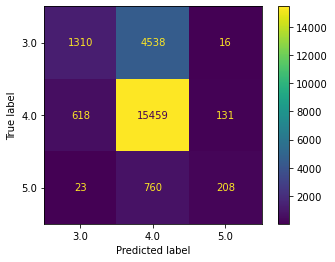

                   mean       std
3.0_precision  0.671332  0.030980
3.0_recall     0.223394  0.018635
3.0_f1-score   0.334981  0.023551
4.0_precision  0.744770  0.003226
4.0_recall     0.953788  0.005619
4.0_f1-score   0.836410  0.003229
5.0_precision  0.588581  0.085596
5.0_recall     0.209960  0.047321
5.0_f1-score   0.307266  0.057452
accuracy       0.736114  0.005201



selected 300 features

StackingCVClassifier prediction took 394.88301610946655 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.644898    0.269165      0.379808       0.750992    0.933991   
1       0.674757    0.236797      0.350567       0.748425    0.952498   
2       0.679245    0.245734      0.360902       0.746854    0.951882   
3       0.611111    0.206485      0.308673       0.738462    0.947563   
4       0.703349    0.250853      0.369811       0.749396    0.957434   
5       0.643564    0.221843      0.329949       0.744108    0.954349   
6       0.670330    0.2

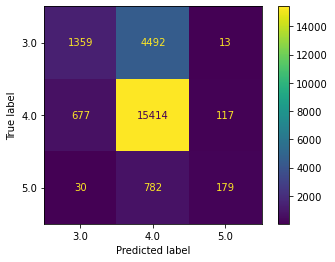

                   mean       std
3.0_precision  0.657760  0.025477
3.0_recall     0.231749  0.020133
3.0_f1-score   0.342390  0.023575
4.0_precision  0.745094  0.004144
4.0_recall     0.951012  0.007097
4.0_f1-score   0.835535  0.003473
5.0_precision  0.596912  0.120292
5.0_recall     0.180667  0.028572
5.0_f1-score   0.275303  0.039705
accuracy       0.735030  0.005453





In [6]:
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingCVClassifier

mnb = MultinomialNB(alpha = 1)
linearSVM = svm.LinearSVC(C=5, dual = False, random_state = 30027)
logr = LogisticRegression(solver='sag', max_iter=50, random_state = 30027)
dt = DecisionTreeClassifier(max_depth = 200, random_state = 30027)
sclf = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, dt], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)

train_df_50 = pd.read_csv("./Final/Datasets/train_df_50.csv", keep_default_na=False)
train_df_100 = pd.read_csv("./Final/Datasets/train_df_100.csv", keep_default_na=False)
train_df_200 = pd.read_csv("./Final/Datasets/train_df_200.csv", keep_default_na=False)
train_df_300 = pd.read_csv("./Final/Datasets/train_df_300.csv", keep_default_na=False)
nums = ['50', '100', '200', '300']
train_dfs = [pd.read_csv("./Final/Datasets/train_df_"+num+".csv", keep_default_na=False) for num in nums]

for i in range(4): 
    print("================================================================================")
    print(f'selected {nums[i]} features\n')
    train_df = train_dfs[i]
    X_train = train_df.iloc[:,:-1]
    y_train = train_df.iloc[:,-1]
    _, report = cross_val_report(sclf, X_train, y_train)
    print(report)
    print('\n================================================================================\n')